## Importing libraries

In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false" # To suppress tokenizer parallelism warnings

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score

In [4]:
!pip install datasketch
from datasketch import MinHash, MinHashLSH
from datasets import Dataset

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight

In [6]:
from transformers import RobertaTokenizerFast, RobertaForTokenClassification, Trainer, TrainingArguments, EarlyStoppingCallback, DataCollatorWithPadding
import torch
import torch.nn as nn

In [7]:
import warnings
from transformers import logging
warnings.filterwarnings("ignore")
logging.set_verbosity_error()

In [8]:
# plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


## Data Loading

In [9]:
!pip install pyarrow

In [ ]:
df = pd.read_parquet("0000.parquet")  # Let pandas choose the engine
df.head()

,document_name,words,pos_tags,met_type,meta
0,a1e-fragment01,"[Latest, corporate, unbundler, reveals, laid-b...","[AJS, AJ0, NN1, VVZ, AJ0, NN1, PUN, NP0, NP0, ...","[{'type': 'mrw/met', 'word_indices': [3]}, {'t...","[N/A, N/A, N/A, N/A, N/A, N/A, N/A, N/A, N/A, ..."
1,a1e-fragment01,"[By, FRANK, KANE]","[PRP, NP0, NP0-NN1]",[],"[N/A, N/A, N/A]"
2,a1e-fragment01,"[IT, SEEMS, that, Roland, Franklin, ,, the, la...","[PNP, VVZ, CJT, NP0, NP0, PUN, AT0, AJS, NN1, ...","[{'type': 'mrw/met', 'word_indices': [16]}, {'...","[N/A, N/A, N/A, N/A, N/A, N/A, N/A, N/A, N/A, ..."
3,a1e-fragment01,"[He, has, not, properly, investigated, the, ta...","[PNP, VHZ, XX0, AV0, VVN, AT0, NN1, POS, NN1, ...","[{'type': 'mrw/met', 'word_indices': [6]}]","[N/A, N/A, N/A, N/A, N/A, N/A, N/A, N/A, N/A, ..."
4,a1e-fragment01,"[The, 63-year-old, head, of, Pembridge, Invest...","[AT0, AJ0, NN1, PRF, NP0, NN2, PUN, PRP, DTQ, ...","[{'type': 'mrw/met', 'word_indices': [2]}, {'t...","[N/A, N/A, N/A, N/A, N/A, N/A, N/A, N/A, N/A, ..."


In [11]:
df = df.iloc[:, :-1]  # dropping the last column
df = df[df['met_type'].apply(lambda x: len(x) > 0)] # keeping only sent with metaphors
df.shape

(8220, 4)

The dataset description can be found here: http://www.vismet.org/metcor/manual/index.php

# RoBERTa token classification model

## Preprocessing the data for the classification

In [12]:
# create a copy of df
sent_df = df.copy()
sent_df.head()

,document_name,words,pos_tags,met_type
0,a1e-fragment01,"[Latest, corporate, unbundler, reveals, laid-b...","[AJS, AJ0, NN1, VVZ, AJ0, NN1, PUN, NP0, NP0, ...","[{'type': 'mrw/met', 'word_indices': [3]}, {'t..."
2,a1e-fragment01,"[IT, SEEMS, that, Roland, Franklin, ,, the, la...","[PNP, VVZ, CJT, NP0, NP0, PUN, AT0, AJS, NN1, ...","[{'type': 'mrw/met', 'word_indices': [16]}, {'..."
3,a1e-fragment01,"[He, has, not, properly, investigated, the, ta...","[PNP, VHZ, XX0, AV0, VVN, AT0, NN1, POS, NN1, ...","[{'type': 'mrw/met', 'word_indices': [6]}]"
4,a1e-fragment01,"[The, 63-year-old, head, of, Pembridge, Invest...","[AT0, AJ0, NN1, PRF, NP0, NN2, PUN, PRP, DTQ, ...","[{'type': 'mrw/met', 'word_indices': [2]}, {'t..."
5,a1e-fragment01,"[If, he, had, taken, his, own, rule, seriously...","[CJS, PNP, VHD, VVN, DPS, DT0, NN1, AV0, PUN, ...","[{'type': 'mrw/met', 'word_indices': [3]}, {'t..."


In [13]:
# Create a 'labels' column in df with lists of 0s and 1s
sent_df['labels'] = sent_df.apply(lambda row: [1 if any(idx in ann.get('word_indices', []) for ann in row['met_type']) else 0 for idx in range(len(row['words']))], axis=1)
sent_df=sent_df.drop(columns=['met_type'])

sent_df.head()

,document_name,words,pos_tags,labels
0,a1e-fragment01,"[Latest, corporate, unbundler, reveals, laid-b...","[AJS, AJ0, NN1, VVZ, AJ0, NN1, PUN, NP0, NP0, ...","[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
2,a1e-fragment01,"[IT, SEEMS, that, Roland, Franklin, ,, the, la...","[PNP, VVZ, CJT, NP0, NP0, PUN, AT0, AJS, NN1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,a1e-fragment01,"[He, has, not, properly, investigated, the, ta...","[PNP, VHZ, XX0, AV0, VVN, AT0, NN1, POS, NN1, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
4,a1e-fragment01,"[The, 63-year-old, head, of, Pembridge, Invest...","[AT0, AJ0, NN1, PRF, NP0, NN2, PUN, PRP, DTQ, ...","[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."
5,a1e-fragment01,"[If, he, had, taken, his, own, rule, seriously...","[CJS, PNP, VHD, VVN, DPS, DT0, NN1, AV0, PUN, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [14]:
def get_simplified_metaphor_pos(pos_tag, label):
    if label == 0:
        return "na"
    else: # label is 1 (metaphorical)
        if pos_tag.startswith("V"):
            return "verb"
        elif pos_tag.startswith("N"):
            return "noun"
        elif pos_tag.startswith("AJ"):
            return "adj"
        else:
            return "other"

# Apply the function element-wise to the lists of pos_tags and labels
sent_df['simple_pos'] = sent_df.apply(
    lambda row: [get_simplified_metaphor_pos(pos, label) for pos, label in zip(row['pos_tags'], row['labels'])],
    axis=1
)

sent_df = sent_df.drop(columns=['pos_tags'])

# Display the first few rows with the new 'simple_pos' column
sent_df.head()

,document_name,words,labels,simple_pos
0,a1e-fragment01,"[Latest, corporate, unbundler, reveals, laid-b...","[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[na, na, na, verb, na, noun, na, na, na, na, n..."
2,a1e-fragment01,"[IT, SEEMS, that, Roland, Franklin, ,, the, la...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[na, na, na, na, na, na, na, na, na, na, na, n..."
3,a1e-fragment01,"[He, has, not, properly, investigated, the, ta...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]","[na, na, na, na, na, na, noun, na, na, na, na]"
4,a1e-fragment01,"[The, 63-year-old, head, of, Pembridge, Invest...","[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...","[na, na, noun, na, na, na, na, other, na, na, ..."
5,a1e-fragment01,"[If, he, had, taken, his, own, rule, seriously...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[na, na, na, verb, na, na, na, na, na, na, na,..."


In [15]:
# average sentence length
print(f"Average sentence length: {sent_df['words'].apply(len).mean():.2f} tokens")
# max and min
print(f"Max sentence length: {sent_df['words'].apply(len).max()} tokens")
print(f"Min sentence length: {sent_df['words'].apply(len).min()} tokens")

Average sentence length: 21.18 tokens
Max sentence length: 127 tokens
Min sentence length: 1 tokens


In [16]:
# keep sentences with at least 3 words
sent_df = sent_df[sent_df['words'].apply(len) >= 3]
sent_df.shape

(8193, 4)

In [17]:
# Initialize tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained("distilroberta-base", add_prefix_space=True)

In [18]:
class MetaphorSentenceDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=64):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

        # Encodings for Trainer
        self.encodings = {
            'input_ids': [],
            'attention_mask': [],
            'labels': []
        }

        # Separate lists to use later for evaluation
        self.word_ids_list = []
        self.simple_pos_list = []

        # POS mapping (simplified)
        self.simple_pos_mapping = {'na': 'na', 'verb': 'verb', 'noun': 'noun',
                                   'adj': 'adj', 'other': 'other', 'SPECIAL': 'SPECIAL',
                                   'SUBWORD': 'SUBWORD', 'UNKNOWN_POS': 'UNKNOWN_POS', 'PAD': 'PAD'}

        for idx, row in self.df.iterrows():
            words = [str(w) for w in row["words"]]
            labels = [int(l) for l in row["labels"]]
            simple_pos = [str(p) for p in row["simple_pos"]]

            encoding = self.tokenizer(
                words,
                is_split_into_words=True,
                padding="max_length",
                truncation=True,
                max_length=self.max_len,
                return_tensors="pt"
            )

            word_ids = encoding.word_ids(batch_index=0)
            aligned_labels = []
            aligned_pos = []

            prev_word_id = None
            for i, word_id in enumerate(word_ids):
                if word_id is None:
                    aligned_labels.append(-100)
                    aligned_pos.append("SPECIAL")
                elif word_id != prev_word_id:
                    aligned_labels.append(labels[word_id])
                    aligned_pos.append(simple_pos[word_id])
                    prev_word_id = word_id
                else:
                    aligned_labels.append(-100)
                    aligned_pos.append("SUBWORD")

            # Convert to tensors
            self.encodings['input_ids'].append(encoding['input_ids'].squeeze(0))
            self.encodings['attention_mask'].append(encoding['attention_mask'].squeeze(0))
            self.encodings['labels'].append(torch.tensor(aligned_labels, dtype=torch.long))

            # Save for evaluation
            self.word_ids_list.append(word_ids)
            self.simple_pos_list.append(aligned_pos)

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        # Support both single index and batch (list/ndarray) index
        if isinstance(idx, (int, np.integer)):
            return {key: self.encodings[key][idx] for key in self.encodings}
        # If idx is a list, tuple, or np.ndarray, return a batch
        if isinstance(idx, (list, tuple, np.ndarray)):
            return {key: [self.encodings[key][i] for i in idx] for key in self.encodings}
        raise TypeError(f"Invalid index type: {type(idx)}")


In [19]:
# # Example alignment:
# Original words: ["running", "quickly", "home"]
# Original labels: [1, 0, 0]  # "running" is metaphorical

# # After tokenization:
# Tokens: ["<s>", "running", "quickly", "home", "</s>", "<pad>", "<pad>"]
# Labels: [-100, 1, 0, 0, -100, -100, -100]
# #        ^     ^  ^  ^   ^     ^      ^
# #        |     |  |  |   |     |      └─ padding
# #        |     |  |  |   |     └─ padding
# #        |     |  |  |   └─ end token (ignore)
# #        |     |  |  └─ "home" (literal)
# #        |     |  └─ "quickly" (literal)
# #        |     └─ "running" (metaphor)
# #        └─ start token (ignore)

## Train-test split

In [20]:
sent_df.head()

,document_name,words,labels,simple_pos
0,a1e-fragment01,"[Latest, corporate, unbundler, reveals, laid-b...","[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[na, na, na, verb, na, noun, na, na, na, na, n..."
2,a1e-fragment01,"[IT, SEEMS, that, Roland, Franklin, ,, the, la...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[na, na, na, na, na, na, na, na, na, na, na, n..."
3,a1e-fragment01,"[He, has, not, properly, investigated, the, ta...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]","[na, na, na, na, na, na, noun, na, na, na, na]"
4,a1e-fragment01,"[The, 63-year-old, head, of, Pembridge, Invest...","[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...","[na, na, noun, na, na, na, na, other, na, na, ..."
5,a1e-fragment01,"[If, he, had, taken, his, own, rule, seriously...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[na, na, na, verb, na, na, na, na, na, na, na,..."


In [21]:
# Split by documents to prevent leakage
doc_ids_all = sent_df["document_name"].unique()

# First split into train and temp (validation + test) document IDs
train_ids, temp_ids = train_test_split(doc_ids_all, test_size=0.3, random_state=42) # e.g., 70% train, 30% temp

# Split temp into validation and test document IDs
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42) # e.g., 15% validation, 15% test

# Create sentence-level DataFrames for train, validation, and test using filtered document IDs
train_df_all = sent_df[sent_df["document_name"].isin(train_ids)].copy().reset_index(drop=True)
val_df_all   = sent_df[sent_df["document_name"].isin(val_ids)].copy().reset_index(drop=True)
test_df_all  = sent_df[sent_df["document_name"].isin(test_ids)].copy().reset_index(drop=True)

print(f"Train size (all sentences): {len(train_df_all)}")
print(f"Val size (all sentences): {len(val_df_all)}")
print(f"Test size (all sentences): {len(test_df_all)}")

Train size (all sentences): 5725
Val size (all sentences): 1416
Test size (all sentences): 1052


In [22]:
# Sample from the filtered and split dataframes
train_df_sampled = train_df_all.sample(n=2000, random_state=42).reset_index(drop=True)
val_df_sampled   = val_df_all.sample(n=500, random_state=42).reset_index(drop=True)
test_df_sampled  = test_df_all.sample(n=500, random_state=42).reset_index(drop=True)

print(f"Train size: {len(train_df_sampled)}")
print(f"Val size: {len(val_df_sampled)}")
print(f"Test size: {len(test_df_sampled)}")

# Create the datasets from the sampled dataframes
train_dataset = MetaphorSentenceDataset(train_df_sampled, tokenizer, max_len=32)
val_dataset = MetaphorSentenceDataset(val_df_sampled, tokenizer, max_len=32)
test_dataset = MetaphorSentenceDataset(test_df_sampled, tokenizer, max_len=32)


train_dataset_all = MetaphorSentenceDataset(train_df_all, tokenizer, max_len=32)
val_dataset_all = MetaphorSentenceDataset(val_df_all, tokenizer, max_len=32)
test_dataset_all = MetaphorSentenceDataset(test_df_all, tokenizer, max_len=32)

Train size: 2000
Val size: 500
Test size: 500


In [23]:
# display test_dataset
test_dataset[0]

{'input_ids': tensor([   0,  152,  936,   34, 2504,    7,    5,  987,  479,    2,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor([-100,    1,    0,    0,    1,    1,    0,    0,    0, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100])}

## Baseline Model 

In [25]:
model = RobertaForTokenClassification.from_pretrained("distilroberta-base", num_labels=2)

training_args = TrainingArguments(
    output_dir="./metaphor_model_fast",
    learning_rate=2e-5,   # learning rate 
    per_device_train_batch_size=64,  
    per_device_eval_batch_size=64, 
    num_train_epochs=3, 
    weight_decay=0.01,  # to prevent overfitting     
    dataloader_num_workers=4,  # parallel data loading
    metric_for_best_model="eval_f1", # to use in EarlyStoppingCallback
    fp16=True,            # Mixed precision for speed
    remove_unused_columns=False, # Added to prevent Trainer from trying to remove columns
)


def compute_metrics(eval_pred):

    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=-1)

    # Remove ignored index (our -100 values)
    predictions = predictions[labels != -100].flatten()
    labels = labels[labels != -100].flatten()

    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


trainer = Trainer( # Use the standard Trainer here
    model=model,
    args=training_args,
    train_dataset=train_dataset, # Use the tokenized dataset
    eval_dataset=test_dataset,   # Use the tokenized dataset
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  # from before
)

trainer.train()

{'train_runtime': 328.6474, 'train_samples_per_second': 18.257, 'train_steps_per_second': 0.292, 'train_loss': 0.29806752999623615, 'epoch': 3.0}


TrainOutput(global_step=96, training_loss=0.29806752999623615, metrics={'train_runtime': 328.6474, 'train_samples_per_second': 18.257, 'train_steps_per_second': 0.292, 'train_loss': 0.29806752999623615, 'epoch': 3.0})

In [26]:
y_true = [label for labels in train_df_all["labels"] for label in labels]
# Simple overall performance
predictions = trainer.predict(test_dataset)
y_pred_logits = predictions.predictions
y_pred = y_pred_logits.argmax(axis=-1)

# Filter out ignored tokens
mask = predictions.label_ids != -100
y_pred_clean = y_pred[mask]
y_true_clean = predictions.label_ids[mask]

print("Overall Performance:")
print(classification_report(y_true_clean, y_pred_clean, target_names=['Literal', 'Metaphor']))

Overall Performance:
              precision    recall  f1-score   support

     Literal       0.92      0.96      0.94      7571
    Metaphor       0.72      0.56      0.63      1352

    accuracy                           0.90      8923
   macro avg       0.82      0.76      0.79      8923
weighted avg       0.89      0.90      0.90      8923



## Class balancing

In [27]:
# Calculate class weights for imbalanced data
train_labels_flat = [label for labels in train_df_all["labels"] for label in labels]
unique_classes = np.unique(train_labels_flat)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=train_labels_flat)

print(f"Class distribution in training data:")
print(f"Literal (0): {train_labels_flat.count(0)} tokens ({100*train_labels_flat.count(0)/len(train_labels_flat):.1f}%)")
print(f"Metaphor (1): {train_labels_flat.count(1)} tokens ({100*train_labels_flat.count(1)/len(train_labels_flat):.1f}%)")
print(f"Enhanced class weights: Literal={class_weights[0]:.2f}, Metaphor={class_weights[1]:.2f}")


Class distribution in training data:
Literal (0): 100929 tokens (85.0%)
Metaphor (1): 17798 tokens (15.0%)
Enhanced class weights: Literal=0.59, Metaphor=3.34


### Custom Trainer with Weighted Loss

In [28]:
class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = torch.FloatTensor(class_weights)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        #Enhanced compute_loss with weighted cross entropy for class imbalance
        expected_keys = ["input_ids", "attention_mask", "labels"]
        model_inputs = {key: inputs[key] for key in expected_keys if key in inputs}

        labels = model_inputs.get("labels") # Get labels separately as they are used in loss calculation

        # Pass expected inputs to the model
        outputs = model(**model_inputs)
        logits = outputs.get("logits")

        # Move class weights to correct device
        device = logits.device
        class_weights_device = self.class_weights.to(device)

        # Create weighted cross entropy loss
        loss_fct = nn.CrossEntropyLoss(weight=class_weights_device, ignore_index=-100)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

In [29]:
# Enhanced compute metrics with detailed class-specific metrics
def compute_metrics_enhanced(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=-1)

    # Remove ignored index (-100 values)
    predictions = predictions[labels != -100].flatten()
    labels = labels[labels != -100].flatten()

    # Calculate metrics for both classes
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None, zero_division=0)
    weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted', zero_division=0)
    acc = accuracy_score(labels, predictions)

    return {
        'accuracy': acc,
        'f1': weighted_f1,
        'precision': weighted_precision,
        'recall': weighted_recall,
        'literal_f1': f1[0] if len(f1) > 0 else 0.0,
        'metaphor_f1': f1[1] if len(f1) > 1 else 0.0,
        'literal_precision': precision[0] if len(precision) > 0 else 0.0,
        'metaphor_precision': precision[1] if len(precision) > 1 else 0.0,
        'literal_recall': recall[0] if len(recall) > 0 else 0.0,
        'metaphor_recall': recall[1] if len(recall) > 1 else 0.0,
    }

In [30]:
# Create model and training configuration
model_balanced = RobertaForTokenClassification.from_pretrained("distilroberta-base", num_labels=2)

training_args_bal = TrainingArguments(
    output_dir="./metaphor_model_fast_balanced",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    dataloader_num_workers=4,
    fp16=True,
    remove_unused_columns=False,
)



# Initialize weighted trainer
trainer_balanced = WeightedTrainer(
    class_weights=class_weights,
    model=model_balanced,
    args=training_args_bal,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_enhanced,
)

# Train the balanced model
print("Training class-balanced RoBERTa model")
trainer_balanced.train()

print("Class-balanced training completed with enhanced metaphor detection")

Training class-balanced RoBERTa model
{'train_runtime': 331.6105, 'train_samples_per_second': 18.094, 'train_steps_per_second': 0.289, 'train_loss': 0.41568219661712646, 'epoch': 3.0}
Class-balanced training completed with enhanced metaphor detection


In [31]:
# Evaluate the balanced model
predictions = trainer_balanced.predict(test_dataset)
y_pred_logits = predictions.predictions
y_pred = y_pred_logits.argmax(axis=-1)
mask = predictions.label_ids != -100  # Only consider non-ignored tokens
y_true_clean = predictions.label_ids[mask].flatten()
y_pred_clean = y_pred[mask].flatten()

print("Overall Performance (Class-Balanced Model):")
print(classification_report(y_true_clean, y_pred_clean, target_names=['Literal', 'Metaphor'], zero_division=0))

aligned_pos_clean = []

for i, mask_row in enumerate(mask):
    word_ids = test_dataset.word_ids_list[i]
    simple_pos = test_dataset.simple_pos_list[i]

    aligned_pos_clean.extend([simple_pos[j] for j, m in enumerate(mask_row) if m])



pos_comparisons = {
    "Noun vs. Literal": ["noun", "na"],
    "Adjective vs. Literal": ["adj", "na"],
    "Verb vs. Literal": ["verb", "na"],
    "Other vs. Literal": ["other", "na"]
}

for comp_name, categories in pos_comparisons.items():
    comparison_mask = np.array([pos in categories for pos in aligned_pos_clean])

    if comparison_mask.sum() > 0:
        y_true_sub = y_true_clean[comparison_mask]
        y_pred_sub = y_pred_clean[comparison_mask]

        print(f"\n Classification Report for '{comp_name}'")
        print(classification_report(y_true_sub, y_pred_sub, target_names=['Literal', 'Metaphor'], zero_division=0))
    else:
        print(f"Comparison '{comp_name}': No relevant tokens found.")

Overall Performance (Class-Balanced Model):
              precision    recall  f1-score   support

     Literal       0.97      0.84      0.90      7571
    Metaphor       0.49      0.87      0.63      1352

    accuracy                           0.84      8923
   macro avg       0.73      0.86      0.76      8923
weighted avg       0.90      0.84      0.86      8923


 Classification Report for 'Noun vs. Literal'
              precision    recall  f1-score   support

     Literal       0.99      0.84      0.91      7571
    Metaphor       0.16      0.74      0.26       311

    accuracy                           0.83      7882
   macro avg       0.57      0.79      0.58      7882
weighted avg       0.95      0.83      0.88      7882


 Classification Report for 'Adjective vs. Literal'
              precision    recall  f1-score   support

     Literal       1.00      0.84      0.91      7571
    Metaphor       0.07      0.77      0.13       124

    accuracy                           

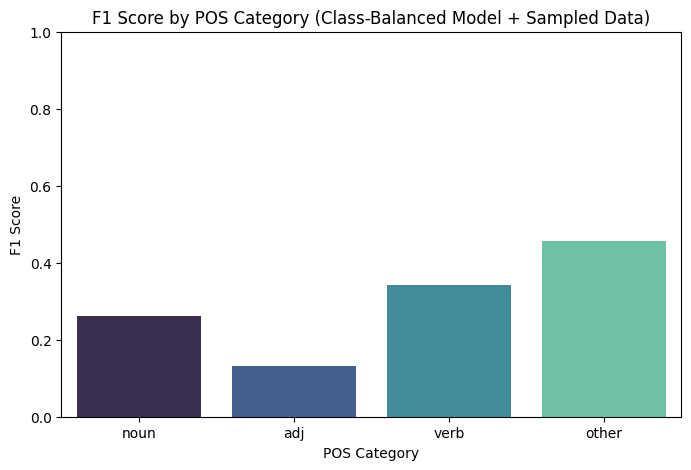

In [32]:
# # F1 Score by POS Category
# Prepare data for plotting
pos_labels = ['noun', 'adj', 'verb', 'other']
f1_scores = []
for pos in pos_labels:
    comparison_mask = np.array([p == pos or p == 'na' for p in aligned_pos_clean])
    if comparison_mask.sum() > 0:
        y_true_sub = y_true_clean[comparison_mask]
        y_pred_sub = y_pred_clean[comparison_mask]
        f1 = precision_recall_fscore_support(y_true_sub, y_pred_sub, average=None, zero_division=0)[2]
        f1_scores.append(f1[1] if len(f1) > 1 else 0.0)
    else:
        f1_scores.append(0.0)
df_f1 = pd.DataFrame({'POS': pos_labels, 'F1 Score': f1_scores})
plt.figure(figsize=(8, 5))
sns.barplot(x='POS', y='F1 Score', data=df_f1, palette='mako')
plt.title('F1 Score by POS Category (Class-Balanced Model + Sampled Data)')
plt.ylim(0, 1)
plt.ylabel('F1 Score')
plt.xlabel('POS Category')
plt.show()

## Optimizing Class Weights

In [33]:
def quick_evaluate_balance(weights, train_size=1000, val_size=400):
    # Quickly evaluate class weights on small samples

    # Tiny training and validation datasets
    tiny_train_dataset = MetaphorSentenceDataset(
        train_df_all.sample(train_size, random_state=42), tokenizer, max_len=32
    )
    tiny_val_dataset = MetaphorSentenceDataset(
        val_df_all.sample(val_size, random_state=42), tokenizer, max_len=32
    )

    # Ultra-fast training
    quick_args = TrainingArguments(
        output_dir="./temp_model",
        eval_strategy="no",
        save_strategy="no",
        learning_rate=1e-4,
        per_device_train_batch_size=32,
        num_train_epochs=1,
        logging_steps=999999,
        warmup_steps=0,
        fp16=True,
        remove_unused_columns=False
    )

    model = RobertaForTokenClassification.from_pretrained("distilroberta-base", num_labels=2)
    trainer = WeightedTrainer(
        class_weights=weights,
        model=model,
        args=quick_args,
        train_dataset=tiny_train_dataset,
        tokenizer=tokenizer,
    )

    trainer.train()

    # Evaluate
    preds = trainer.predict(tiny_val_dataset)
    y_pred = preds.predictions.argmax(axis=-1)
    mask = preds.label_ids != -100
    y_true, y_pred_clean = preds.label_ids[mask], y_pred[mask]

    # Return metaphor F1
    f1_scores = precision_recall_fscore_support(y_true, y_pred_clean, average=None, zero_division=0)[2]
    return f1_scores[1] if len(f1_scores) > 1 else 0


# Test different class weight multipliers
balance_results = {}
for m in [0.3, 0.4, 0.5, 0.6]:
    balance_results[m] = quick_evaluate_balance([class_weights[0], class_weights[1] * m])
    print(f"Multiplier {m}: Metaphor F1 = {balance_results[m]:.3f}")

best_multiplier = max(balance_results, key=balance_results.get)
final_weights = [class_weights[0], class_weights[1] * best_multiplier]
print(f"Best balance multiplier: {best_multiplier}")


{'train_runtime': 56.9667, 'train_samples_per_second': 17.554, 'train_steps_per_second': 0.562, 'train_loss': 0.3684573173522949, 'epoch': 1.0}
Multiplier 0.3: Metaphor F1 = 0.680
{'train_runtime': 56.7521, 'train_samples_per_second': 17.62, 'train_steps_per_second': 0.564, 'train_loss': 0.3953898251056671, 'epoch': 1.0}
Multiplier 0.4: Metaphor F1 = 0.665
{'train_runtime': 56.6211, 'train_samples_per_second': 17.661, 'train_steps_per_second': 0.565, 'train_loss': 0.413275808095932, 'epoch': 1.0}
Multiplier 0.5: Metaphor F1 = 0.649
{'train_runtime': 56.4589, 'train_samples_per_second': 17.712, 'train_steps_per_second': 0.567, 'train_loss': 0.4278331696987152, 'epoch': 1.0}
Multiplier 0.6: Metaphor F1 = 0.623
Best balance multiplier: 0.3


In [34]:

# Create model and training configuration
model_balanced = RobertaForTokenClassification.from_pretrained("distilroberta-base", num_labels=2)

training_args_bal_fast = TrainingArguments(
    output_dir="./metaphor_model_fast_balanced",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    dataloader_num_workers=4,
    fp16=True,
    remove_unused_columns=False,
)

# Initialize weighted trainer
trainer_balanced = WeightedTrainer(
    class_weights=final_weights,
    model=model_balanced,
    args=training_args_bal_fast,
    train_dataset=train_dataset_all,
    eval_dataset=val_dataset_all,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_enhanced,
)

# Train the balanced model
print("Training class-balanced RoBERTa model with optimized weights")
trainer_balanced.train()

print("Class-balanced training completed with enhanced metaphor detection")

Training class-balanced RoBERTa model with optimized weights
{'train_runtime': 930.2326, 'train_samples_per_second': 18.463, 'train_steps_per_second': 0.29, 'train_loss': 0.2558425338179977, 'epoch': 3.0}
Class-balanced training completed with enhanced metaphor detection


### Qualitative evaluation

In [39]:
preds_out = trainer_balanced.predict(test_dataset)
logits = preds_out.predictions           
y_pred = logits.argmax(axis=-1)          
y_true = preds_out.label_ids             

rows = []
n_samples = y_pred.shape[0]

for i in range(n_samples):
    word_ids = test_dataset.word_ids_list[i]
    pos_seq = test_dataset.simple_pos_list[i]
    sentence_words = test_dataset.df.loc[i, "words"]
    input_ids = test_dataset.encodings["input_ids"][i].tolist()

    seq_len = min(len(word_ids), y_pred.shape[1], len(input_ids), len(y_true[i]))
    for j in range(seq_len):
        if y_true[i][j] == -100:
            continue

        wid = word_ids[j]
        if wid is None or not (0 <= wid < len(sentence_words)):
            continue

        rows.append({
            "original_word": sentence_words[wid],
            "pos": pos_seq[j],
            "true_label": "Metaphor" if int(y_true[i][j]) == 1 else "Literal",
            "pred_label": "Metaphor" if int(y_pred[i][j]) == 1 else "Literal",
            "sentence": " ".join(sentence_words)
        })

df_tokens = pd.DataFrame(rows)

# Keep only true metaphors
df_tokens = df_tokens[df_tokens["true_label"] == "Metaphor"].reset_index(drop=True)

# Set pandas to display the full content of each column (no truncation)
pd.set_option('display.max_colwidth', None)

df_tokens.sample(10)

,original_word,pos,true_label,pred_label,sentence
1081,in,other,Metaphor,Metaphor,"Then his example lured his elder son Bertrand to Tripoli in 1112 , and his younger son Alphonse Jourdain there in 1147 ."
550,down,other,Metaphor,Literal,"It was Paula 's job to show samples , parading slowly up and down in front of the clients as they sat on the elegant spindle-leg chairs taking in every detail of the garments with a critical and practised eye ."
486,that,other,Metaphor,Metaphor,"just turn them off , and that 's it Just normal conversations the words that people use in common different areas of the country , with accents and th dialect and one thing and another it 's for the Oxford English Dictionary the next edition ."
296,to,other,Metaphor,Metaphor,The magnetic force is perpendicular both to the direction of motion ( +z axis ) and the direction of magnetic field ( [formula ] direction ) .
1060,approach,noun,Metaphor,Metaphor,"Latest corporate unbundler reveals laid-back approach : Roland Franklin , who is leading a 697m pound break-up bid for DRG , talks to Frank Kane"
1052,drop,noun,Metaphor,Metaphor,"Not really , because ( 1 ) as current flows there is some potential drop in the electrode itself , ( 2 ) zero conductivity for part of the space can not be electrostatically modelled since there are no dielectrics with Er = 0 , and ( 3 ) when current flows through two materials of different conductivity there is generally a surface charge at the boundary ( see Example 3.4 ) ."
1033,to,other,Metaphor,Metaphor,"It would be unfair both to the vector potential and to quantum mechanics to say that none of those formulations have engineering applications ( in fact the most sensitive magnetometer built to date is based on that kind of theory ) , but by and large engineers would n't lose much sleep if the use of A were banned with immediate effect ."
436,virtue,noun,Metaphor,Literal,So the electrons want to move inwards but can not because the ions hold them back by virtue of their electrostatic attraction .
161,world,noun,Metaphor,Metaphor,Her favourite was the coffee shop in Fenwicks in Bond Street for this was the haunt and the meeting place of all those from the world of fashion .
318,little,adj,Metaphor,Metaphor,"And it 'll be really rather dolly , we 'll have a little holiday you see together and we sort of go teaching together and"


## Evaluating the Final Model on Test Set



In [36]:
# Get predictions
preds_out = trainer_balanced.predict(test_dataset_all)
logits = preds_out.predictions
y_pred = logits.argmax(axis=-1)
y_true = preds_out.label_ids
mask = y_true != -100

# Cleaned arrays (only real tokens)
y_true_clean = y_true[mask].flatten()
y_pred_clean = y_pred[mask].flatten()

print("Overall Performance (Class-Balanced Model):")
print(classification_report(y_true_clean, y_pred_clean, target_names=['Literal', 'Metaphor'], zero_division=0))

# Align POS tags with non-ignored tokens
aligned_pos_clean = []
for i, mask_row in enumerate(mask):
    word_ids = test_dataset_all.word_ids_list[i]
    pos_tags = test_dataset_all.simple_pos_list[i]

    aligned_pos_clean.extend([pos_tags[j] for j, m in enumerate(mask_row) if m])

#  POS-Conditioned Classification Reports
pos_comparisons = {
    "Noun vs. Literal": ["noun", "na"],
    "Adjective vs. Literal": ["adj", "na"],
    "Verb vs. Literal": ["verb", "na"],
    "Other vs. Literal": ["other", "na"]
}

for comp_name, categories in pos_comparisons.items():
    comparison_mask = np.array([pos in categories for pos in aligned_pos_clean])

    if comparison_mask.sum() > 0:
        y_true_sub = y_true_clean[comparison_mask]
        y_pred_sub = y_pred_clean[comparison_mask]

        print(f"\nClassification Report for '{comp_name}'")
        print(classification_report(y_true_sub, y_pred_sub, target_names=['Literal', 'Metaphor'], zero_division=0))
    else:
        print(f"Comparison '{comp_name}': No relevant tokens found.")


Overall Performance (Class-Balanced Model):
              precision    recall  f1-score   support

     Literal       0.95      0.95      0.95     15567
    Metaphor       0.73      0.75      0.74      2763

    accuracy                           0.92     18330
   macro avg       0.84      0.85      0.85     18330
weighted avg       0.92      0.92      0.92     18330


Classification Report for 'Noun vs. Literal'
              precision    recall  f1-score   support

     Literal       0.98      0.95      0.97     15567
    Metaphor       0.29      0.54      0.38       600

    accuracy                           0.94     16167
   macro avg       0.64      0.74      0.67     16167
weighted avg       0.96      0.94      0.94     16167


Classification Report for 'Adjective vs. Literal'
              precision    recall  f1-score   support

     Literal       0.99      0.95      0.97     15567
    Metaphor       0.14      0.49      0.22       255

    accuracy                           0.

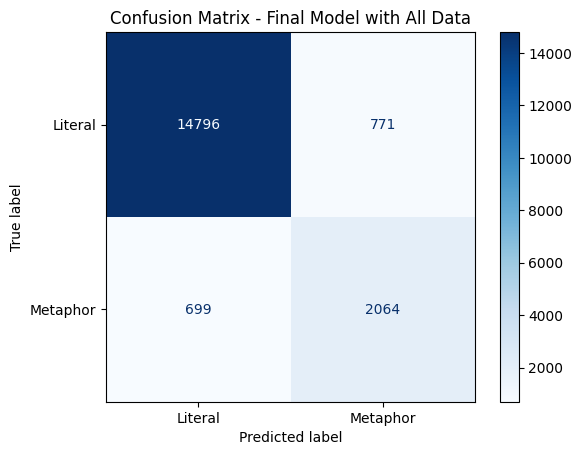

In [37]:
# Compute confusion matrix
cm = confusion_matrix(y_true_clean, y_pred_clean)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Literal', 'Metaphor'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Final Model with All Data")
plt.show()

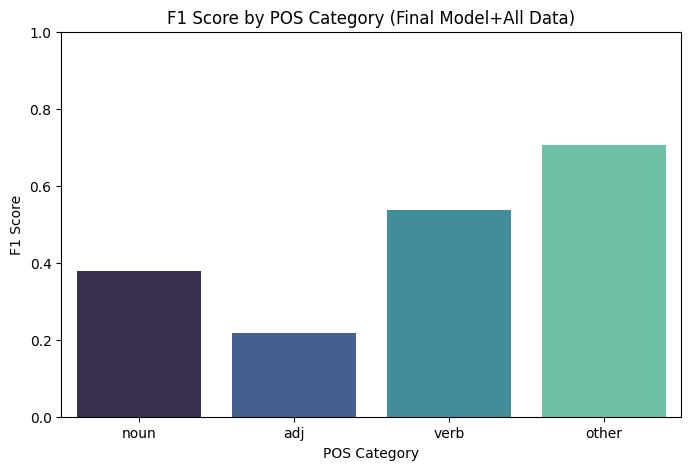

In [38]:
# # F1 Score by POS Category
# Prepare data for plotting
pos_labels = ['noun', 'adj', 'verb', 'other']
f1_scores = []
for pos in pos_labels:
    comparison_mask = np.array([p == pos or p == 'na' for p in aligned_pos_clean])
    if comparison_mask.sum() > 0:
        y_true_sub = y_true_clean[comparison_mask]
        y_pred_sub = y_pred_clean[comparison_mask]
        f1 = precision_recall_fscore_support(y_true_sub, y_pred_sub, average=None, zero_division=0)[2]
        f1_scores.append(f1[1] if len(f1) > 1 else 0.0)
    else:
        f1_scores.append(0.0)
df_f1 = pd.DataFrame({'POS': pos_labels, 'F1 Score': f1_scores})
plt.figure(figsize=(8, 5))
sns.barplot(x='POS', y='F1 Score', data=df_f1, palette='mako')
plt.title('F1 Score by POS Category (Final Model+All Data)')
plt.ylim(0, 1)
plt.ylabel('F1 Score')
plt.xlabel('POS Category')
plt.show()